In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Neural Network with Early Stopping input_hidden_output") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('winPlaceClass', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDis

In [3]:
from pyspark.sql.functions import col

data = data.withColumn("winPlaceClass", col("winPlaceClass") -1)

In [4]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'winPlaceClass']
inputCols = list(set(inputCols) - set(toRemove))

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [6]:
from pyspark.ml.feature import StandardScaler


ss = StandardScaler()

ss.setInputCol("features")

model = ss.fit(output)

model.setOutputCol("features_scaled")

StandardScalerModel: uid=StandardScaler_2092c508bd87, numFeatures=51, withMean=false, withStd=true

In [7]:
output_scaled = model.transform(output)

In [8]:
seed = 42
withReplacement=False
output_sample = output_scaled.sample(withReplacement, .3, seed).withColumnRenamed("winPlaceClass", "label").select("features_scaled", "label")

(training,testing) = output_sample.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 423874
testing: 181516


In [9]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd

def customEarlyStoppingNN(blockSize = 128, layers = [], training = None, iterazioni = 10, optimizerIt=5, es = 5):
    (training,validation) = output_sample.randomSplit([0.8,0.2])
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    models = []
    best_model = 0;
    
    es_count = 0

    for i in range(iterazioni):
        
        trainer = MultilayerPerceptronClassifier(maxIter=optimizerIt, layers=layers, blockSize=blockSize, seed=42)

        if len(models) != 0:
            trainer = trainer.setInitialWeights(models[-1].weights)
        
        model = trainer.fit(training.withColumnRenamed( "features_scaled", "features"))
        
        models.append(model)
        
        trainStat = model.summary()
        
        result = model.transform(validation.withColumnRenamed( "features_scaled", "features"))
        
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", probabilityCol="probability")

        evaluator.setMetricName('logLoss')
        logLoss = evaluator.evaluate(result)
        evaluator.setMetricName('accuracy')
        accuracy = evaluator.evaluate(result)
        
        print(F'Epoch {i+1}*{optimizerIt}: loss: {trainStat.objectiveHistory[0]}, acc: {trainStat.accuracy}, val_loss: {logLoss}, val_acc: {accuracy}')
        
        
        if len(loss_val) != 0:
            if loss_val[best_model] < logLoss:
                es_count = es_count +1
            else:
                es_count = 0
                best_model = len(models)-1
            
        if es_count == es:
            print("Early Stopping")
            break
        
        loss_train.append(trainStat.objectiveHistory[0])
        acc_train.append(trainStat.accuracy)
        loss_val.append(logLoss)
        acc_val.append(accuracy)
    
    df = pd.DataFrame()
    
    df["loss_train"] = loss_train
    df["acc_train"] = acc_train
    df["loss_val"] = loss_val
    df["acc_val"] = acc_val
    
    
    return (df, models[best_model])

In [11]:
%%time
df_risultati, model = customEarlyStoppingNN(blockSize = 200, layers = [51, 80, 6], training = training, iterazioni = 100, optimizerIt=5, es = 5)

Epoch 1*5: loss: 2.1310879900813453, acc: 0.525382115231334, val_loss: 1.148857592176527, val_acc: 0.5256291696941674
Epoch 2*5: loss: 1.1471953683455536, acc: 0.6036202346586051, val_loss: 0.9972380277485554, val_acc: 0.6027148424598718
Epoch 3*5: loss: 0.9950463345726446, acc: 0.6455445012988408, val_loss: 0.9301961857215846, val_acc: 0.6443292159323601
Epoch 4*5: loss: 0.9290002083720893, acc: 0.6600588917935566, val_loss: 0.8980394202669821, val_acc: 0.6580933350947883
Epoch 5*5: loss: 0.8962795496649729, acc: 0.6726136640524657, val_loss: 0.8519097955221567, val_acc: 0.6705611334962679
Epoch 6*5: loss: 0.8504771172072406, acc: 0.6771916130817422, val_loss: 0.8243998298136443, val_acc: 0.675630821058194
Epoch 7*5: loss: 0.8228007019577834, acc: 0.6909750184811203, val_loss: 0.7685334600414022, val_acc: 0.6890976946958187
Epoch 8*5: loss: 0.767109333161949, acc: 0.6923172227522209, val_loss: 0.7485431206088382, val_acc: 0.6910545610674417
Epoch 9*5: loss: 0.7468785814300671, acc: 0.

Epoch 70*5: loss: 0.6386906306473061, acc: 0.7268717554792908, val_loss: 0.6410047568492447, val_acc: 0.7269387013673294
Epoch 71*5: loss: 0.6384069904745219, acc: 0.7271360664742152, val_loss: 0.640696557616862, val_acc: 0.7273432855538675
Epoch 72*5: loss: 0.638109402695299, acc: 0.7271133522480889, val_loss: 0.6404299145344429, val_acc: 0.7271698923310654
Epoch 73*5: loss: 0.6378231536753195, acc: 0.7272269233787205, val_loss: 0.6401323073632237, val_acc: 0.7274836514961358
Epoch 74*5: loss: 0.6375645946812193, acc: 0.727193884504355, val_loss: 0.6399785558326962, val_acc: 0.7272607173525332
Epoch 75*5: loss: 0.6373740050149049, acc: 0.7278794411474401, val_loss: 0.6393436174429854, val_acc: 0.7281607107470771
Epoch 76*5: loss: 0.6367665598635143, acc: 0.7275222083183626, val_loss: 0.6389129917524607, val_acc: 0.7275992469780038
Epoch 77*5: loss: 0.6363136927737656, acc: 0.7279000904439186, val_loss: 0.6383590851261501, val_acc: 0.7278386947618734
Epoch 78*5: loss: 0.635703286595079

In [12]:
df_risultati

,loss_train,acc_train,loss_val,acc_val
0,2.131088,0.525382,1.148858,0.525629
1,1.147195,0.603620,0.997238,0.602715
2,0.995046,0.645545,0.930196,0.644329
3,0.929000,0.660059,0.898039,0.658093
4,0.896280,0.672614,0.851910,0.670561
...,...,...,...,...
95,0.631632,0.728972,0.634129,0.728986
96,0.631416,0.729403,0.633941,0.729507
97,0.631259,0.729145,0.633838,0.729011
98,0.631116,0.729472,0.633668,0.729606


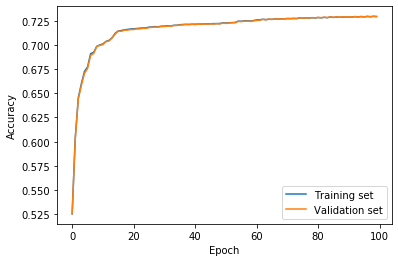

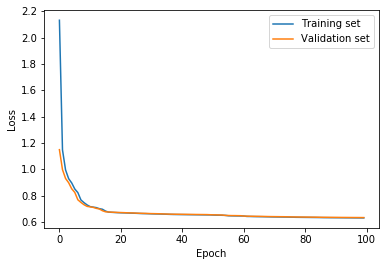

In [13]:
import matplotlib.pyplot as plt

df = pd.DataFrame()

plt.plot(df_risultati["acc_train"], label="Training set")
plt.plot(df_risultati["acc_val"], label="Validation set")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("Accuracy_NN_iho.pdf")
plt.show()


plt.plot(df_risultati["loss_train"], label="Training set")
plt.plot(df_risultati["loss_val"], label="Validation set")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("Loss_NN_iho.pdf")
plt.show()

In [14]:
predictions = model.transform(testing.withColumnRenamed( "features_scaled", "features"))
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|    3|[-3.8736742636669...|[1.32907026629850...|       3.0|
|(51,[0,1,2,3,4,5,...|    2|[-0.5816709684313...|[0.00278547909384...|       2.0|
|(51,[0,1,2,3,4,5,...|    1|[2.01134938348078...|[0.02792014900689...|       2.0|
|(51,[0,1,2,3,4,5,...|    3|[-5.2967314594102...|[3.91910006001723...|       3.0|
|(51,[0,1,2,3,4,5,...|    3|[-2.7300989527499...|[5.84981447819364...|       2.0|
|(51,[0,1,2,3,4,5,...|    2|[-3.0225372025532...|[3.70721255512686...|       3.0|
|(51,[0,1,2,3,4,5,...|    4|[-6.2311631374506...|[5.58732338339217...|       4.0|
|(51,[0,1,2,3,4,5,...|    3|[-2.6915636675462...|[8.15185028565463...|       3.0|
|(51,[0,1,2,3,4,5,...|    2|[-1.1374728483402...|[0.00255654720240...|       2.0|
|(51,[0,1,2,3,4,

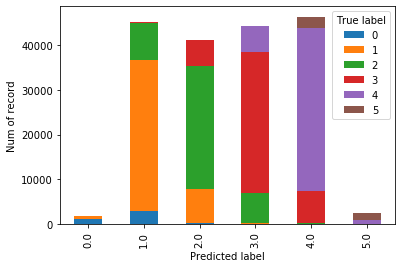

In [15]:
cross_tab = predictions.crosstab('prediction', 'label').toPandas().sort_values(by=["prediction_label"]).set_index('prediction_label')
cross_tab.plot.bar(stacked=True)

plt.ylabel("Num of record")
plt.xlabel("Predicted label")
plt.legend(title="True label")

plt.savefig("confMatrixGraph_NN_iho.pdf")

In [16]:
model.write().overwrite().save("NN.input_hidden_output")

## Evaluation

In [17]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

In [18]:
# Summary stats
print("Recall = %s" % (metrics.weightedRecall))
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [0.0, 1.0 ,2.0, 3.0, 4.0, 5.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.7291588620286917
Precision = 0.7257618226567158
F1 measure = 0.7244813335464642
Accuracy = 0.7291588620286917
Class 0.0 precision = 0.6336580086580087
Class 0.0 recall = 0.2763095799905616
Class 0.0 F1 Measure = 0.3848176141965166
Class 1.0 precision = 0.7494962021392032
Class 1.0 recall = 0.7947634143477751
Class 1.0 F1 Measure = 0.7714663445100408
Class 2.0 precision = 0.6687183463784622
Class 2.0 recall = 0.647443868333998
Class 2.0 F1 Measure = 0.6579091667660031
Class 3.0 precision = 0.7108460896814482
Class 3.0 recall = 0.7051706400679877
Class 3.0 F1 Measure = 0.707996991164352
Class 4.0 precision = 0.7861878928786704
Class 4.0 recall = 0.8458794644925186
Class 4.0 F1 Measure = 0.8149420926963158
Class 5.0 precision = 0.6944558521560575
Class 5.0 recall = 0.40435198469631756
Class 5.0 F1 Measure = 0.5111077527580475
Confusion Matrix
[[1.1710e+03 2.9460e+03 8.6000e+01 1.3000e+01 2.2000e+01 0.0000e+00]
 [6.6300e+02 3.3845e+04 7.7870e+03 2.6900e+02 2.0000e+01 1.0000e+00]

## Sklearn metrics

In [21]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.28      0.38      4238
           1       0.75      0.79      0.77     42585
           2       0.67      0.65      0.66     42623
           3       0.71      0.71      0.71     44714
           4       0.79      0.85      0.81     43174
           5       0.69      0.40      0.51      4182

    accuracy                           0.73    181516
   macro avg       0.71      0.61      0.64    181516
weighted avg       0.73      0.73      0.72    181516



In [24]:
print(confusion_matrix(y_true, y_pred))

[[ 1171  2946    86    13    22     0]
 [  663 33845  7787   269    20     1]
 [   14  8249 27596  6620   133    11]
 [    0   116  5763 31531  7284    20]
 [    0     0    30  5912 36520   712]
 [    0     1     5    12  2473  1691]]
